In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv("../../data/classification/glass6.csv")
X = df.drop('y', axis = 1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2022)

#### 기본

In [3]:
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.metrics import *
model = DTC(random_state = 2022).fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
print(acc, rec)

0.8888888888888888 0.5454545454545454


#### 전처리의 불필요성 확인

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X_train)
Z_train = scaler.transform(X_train)
Z_test = scaler.transform(X_test)
model2 = DTC(random_state = 2022).fit(Z_train, y_train)
z_pred = model2.predict(Z_test)
acc = accuracy_score(y_test, z_pred)
rec = recall_score(y_test, z_pred)
print(acc, rec)

0.8888888888888888 0.5454545454545454


#### 클래스 가중치 설정

In [5]:
num_majority_sample = y_train.value_counts().iloc[0]
num_minority_sample = y_train.value_counts().iloc[-1]
class_imbalance_ratio = num_majority_sample / num_minority_sample
print(class_imbalance_ratio)

8.352941176470589


In [6]:
model3 = DTC(random_state = 2022,
             class_weight = {0:1, 1:class_imbalance_ratio}).fit(X_train, y_train)
y_pred = model3.predict(X_test)
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
print(acc, rec)

0.8888888888888888 0.5454545454545454


In [7]:
model4 = DTC(random_state = 2022,
             class_weight = {0:1, 1:class_imbalance_ratio * 100}).fit(X_train, y_train)
y_pred = model4.predict(X_test)
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
print(acc, rec)

0.9259259259259259 0.6363636363636364


#### 모델 해석

In [18]:
from sklearn.tree import export_text
r = export_text(model, feature_names=list(X_train.columns))
print(r)

|--- x8 <= 0.40
|   |--- x5 <= 74.86
|   |   |--- class: 0
|   |--- x5 >  74.86
|   |   |--- x6 <= 1.35
|   |   |   |--- class: 0
|   |   |--- x6 >  1.35
|   |   |   |--- class: 1
|--- x8 >  0.40
|   |--- x3 <= 2.26
|   |   |--- class: 1
|   |--- x3 >  2.26
|   |   |--- class: 0



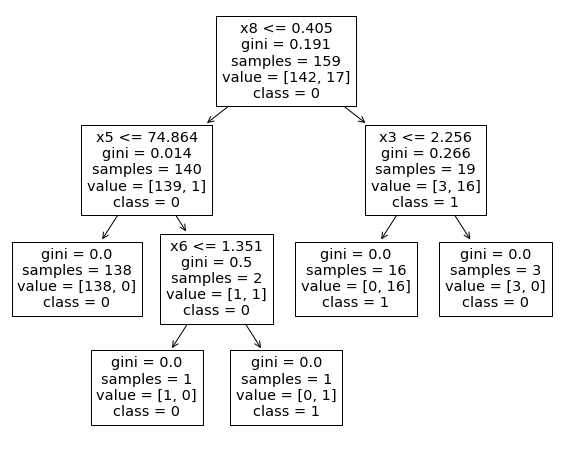

In [24]:
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt
plt.figure(figsize = (10, 8))
plot_tree(model, feature_names=list(X_train.columns), class_names = ["0", "1"])
plt.show()

In [63]:
def text_to_rule_list(r):
    node_list = []
    leaf_node_list = []

    for i, node in enumerate(r.split("\n")[:-1]):
        rule = node.split('- ')[1]
        indent = node.count(' ' * 3)
        if 'class' in rule:
            leaf_node_list.append([i, rule, indent])

        node_list.append([i, rule, indent])

    prediction_rule_list = []
    for leaf_node in leaf_node_list:
        prediction_rule = []
        idx, decision, indent = leaf_node
        for indent_level in range(indent-1, -1, -1):
            for node_idx in range(idx, -1, -1):
                node = node_list[node_idx]
                rule = node[1]
                if node[2] == indent_level and "class" not in node[1]:
                    prediction_rule.append(rule)
                    break
        prediction_rule_list.append([prediction_rule, decision])

    return prediction_rule_list

In [64]:
prediction_rule_list = text_to_rule_list(r)
for prediction_rule, decision in prediction_rule_list:
    print(" & ".join(prediction_rule), decision)

x5 <= 74.86 & x8 <= 0.40 class: 0
x6 <= 1.35 & x5 >  74.86 & x8 <= 0.40 class: 0
x6 >  1.35 & x5 >  74.86 & x8 <= 0.40 class: 1
x3 <= 2.26 & x8 >  0.40 class: 1
x3 >  2.26 & x8 >  0.40 class: 0
